# MLB Game Statistics

Names: Trevor Doucet and Andrew Selius

GitHub Project Website: https://trevordoucet.github.io/baseball/ 

Project Description: Our project aims to look at MLB pitching data in order to find relationships between the various factors of a pitch and their results. Factors such as pitch type, release velocity, and spin rate are a few of the many factors that go into a single pitch, and we aim to see if there are any relationships between these factors and their success rate in yielding strikes against a hitter. Some preliminary questions we have come up with are as follows:

- Is there a relationship between spin-rate and the number of resulting strikes/strikeouts?
- What factors correlate strongest with a strike being called from a given pitch?
- What players exhibit the most successful pitch characteristics as a result of the trends found in the first two questions?

We intend to gather our data from https://baseballsavant.mlb.com/ . This website provides official and comprehensive data from all MLB games, and the dataset used below is a reflection of that vastness. The main challenges we faced involved filtering out features that we found to be depricated or unnecessary (for now, at least).

Additional Datasets are sourced from National Centers for Enviormental Information which contains weather data: https://www.ncdc.noaa.gov/cdo-web/search and a Kaggle dataset that contains relevant information about MLB ballparks https://www.kaggle.com/datasets/paulrjohnson/mlb-ballparks?resource=download.

Since two people are involved in this project, our collaboration plan is as follows:
- Weekly meetings/working sessions over Google Meets, more as needed.
- Communication over text/Whatsapp for updates, meeting coordination, etc. This will be as needed, but from having worked together in the past we expect to communicate multiple times per week in addition to the working sessions.
- GitHub repository (already created) to coordinate code and keep track of versioning.

In [1]:
# Base
import pandas as pd
import numpy as np

# Visuals 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

#Scipy
from scipy.stats import linregress

# Sampling
from imblearn.over_sampling import SMOTE

## Savant Raw Data
The data we will be importing is general pitch data from the top 25 pitchers (ranked by number of pitches thrown) between the dates of 09/19/2023 and 10/01/2023. This will serve as a starting point for our analysis as we look to expand our date range for this analysis.

In [2]:
df = pd.read_csv('../raw Data/savant_data.csv')

### Desired Columns
In the below cell, we are filtering our data to the features we have deemed appropriate (for now). We are looking to see how these factors affect the result of the pitch (noted in the 'events' column).

In [3]:
df.dropna()
df = df[['player_name', 'pitch_type', 'pitch_name', 'release_speed',
           'game_date', 'release_spin_rate', 'description',
           'events', 'hit_distance_sc', 'pitch_number', 'strikes', 'balls', 'home_team', 'inning', 'outs_when_up', 'type',
           'zone', 'spin_axis', 'effective_speed', 'at_bat_number']]

 ### Amount of Pitches by Pitch Type

 Here we will classify the dataset by the popularity of the type of pitch thrown. Pitches with total instances over 1000 will be placed into a separate dataframe, as will pitches below that 1000-count threshold.

In [4]:
pitches_amount = df.groupby('pitch_name').size().to_frame('Total Pitches').reset_index()

In [5]:
more_popular = pitches_amount[pitches_amount['Total Pitches'] >= 1000]
less_popular = pitches_amount[pitches_amount['Total Pitches'] < 1000]

### Bar Plot of Pitch Amounts by Pitch Type
Below are bar charts depicting the frequency of pitches of a certain type. In order to better represent the data, we split the dataset into "more popular" and "less popular" pitch types.

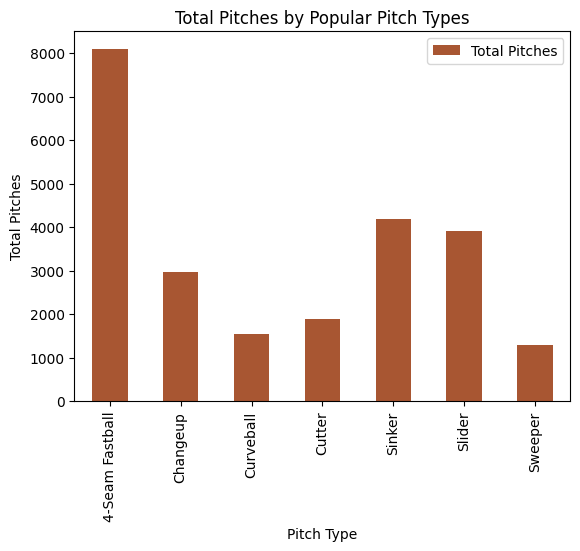

In [6]:
more_popular.plot.bar(x ='pitch_name', y ='Total Pitches', color='#a85632')

plt.xlabel('Pitch Type')
plt.ylabel('Total Pitches')
plt.title('Total Pitches by Popular Pitch Types')
plt.show()

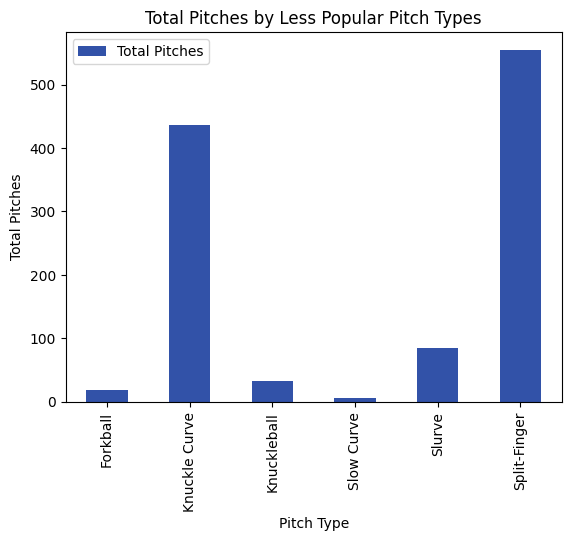

In [7]:
less_popular.plot.bar(x ='pitch_name', y ='Total Pitches', color='#3252a8')

plt.xlabel('Pitch Type')
plt.ylabel('Total Pitches')
plt.title('Total Pitches by Less Popular Pitch Types')
plt.show()

### Interesting Stat
Below is an interesting comparison between two types of pitches. The spin rate of a knuckleball is on average almost 2,000 rpm slower than a 4-seam fastball. Based on the differences between these two pitch types, it invites the question as to whether or not spin rates will have an effect on how difficult it is for a batter to hit.

In [8]:
spin_rate = df[df['pitch_name'] == 'Knuckleball']['release_spin_rate'].mean()
fast_kb = df[df['pitch_name'] == 'Knuckleball']['release_speed'].max()

print(f'Average Knuckleball spin rate is {spin_rate} rpm')
print(f'Fastest Knuckleball recorded was {fast_kb} mph')

Average Knuckleball spin rate is 218.25 rpm
Fastest Knuckleball recorded was 80.9 mph


In [9]:
round(df[df['pitch_name'] == '4-Seam Fastball']['release_spin_rate'].mean(), 2)

2268.28

## Ball Parks


A dataset detailing the physical and environmental dimensions of Major League Baseball (MLB) ballparks (for the 2022 season). These ballpark dimensions are relevant when analysing or predicting outcomes, particularly hitting.

In [10]:
ballparks = pd.read_csv('../raw data/ballparks.csv')

In [11]:
ballparks.head(10)

,team_name,ballpark,left_field,center_field,right_field,min_wall_height,max_wall_height,hr_park_effects,extra_distance,avg_temp,elevation,roof,daytime
0,ATL,Truist Park,335,400,325,11.0,15,99,1.8,79.2,1001,0.00,0.31
1,AZ,Chase Field,328,407,335,7.6,25,84,13.2,80.8,1086,0.81,0.31
2,BAL,Oriole Park at Camden Yards,333,400,318,7.0,21,107,-0.5,76.4,33,0.00,0.35
3,BOS,Fenway Park,310,420,302,3.0,37,102,-4.7,69.5,21,0.00,0.31
4,CHC,Wrigley Field,355,400,353,11.5,15,97,-3.4,70.2,595,0.00,0.55
5,CIN,Great American Ball Park,328,404,325,8.0,12,150,1.6,77.9,535,0.00,0.50
6,CLE,Progressive Field,325,405,325,9.0,19,100,-6.5,70.8,653,0.00,0.36
7,COL,Coors Field,347,415,350,8.0,17,115,22.0,75.4,5190,0.00,0.38
8,CWS,Guaranteed Rate Field,330,400,335,8.0,8,124,-1.7,71.6,595,0.00,0.38
9,DET,Comerica Park,345,420,330,7.0,9,75,-7.7,73.3,600,0.00,0.61


### Ball Parks and Savant Data Cross Over

Here we will merge the ballpark and MLB Savant data into a single dataframe, so we can accurately attribute pitches and games to the stadiums (and the conditions) they were played in.

In [12]:
df_stadium = pd.merge(ballparks, df, how='right', left_on='team_name', right_on='home_team')
df_stadium.drop(columns='team_name', inplace=True)

## Weather

From the National Oceanic and Atmospheric Administration (NOAA), we've gathered climate data from the closest weather stations to a select number of MLB stadiums. We plan on expanding the dataset to include all MLB ballparks, but this current dataset serves a first step in our EDA process.

In [13]:
weather = pd.read_csv('../raw data/MLB_NOAA.csv')

In [14]:
weather['NAME'].unique()

array(['BOSTON LOGAN INTERNATIONAL AIRPORT, MA US',
       'ATLANTA 3.2 S, GA US', 'SAN FRANCISCO 1.6 SE, CA US',
       'CHICAGO NORTHERLY ISLAND, IL US',
       'LOS ANGELES DOWNTOWN USC, CA US',
       'JFK INTERNATIONAL AIRPORT, NY US'], dtype=object)

### Ball Parks and Weather Cross Over

Here we will be mapping the weather stations to each ballpark in the ballpark data set.

In [15]:
airport_to_ballpark = {
       'BOSTON LOGAN INTERNATIONAL AIRPORT, MA US': 'Fenway Park',
       'ATLANTA 3.2 S, GA US': 'Truist Park',
       'SAN FRANCISCO 1.6 SE, CA US': 'Oracle Park',
       'CHICAGO NORTHERLY ISLAND, IL US': 'Wrigley Field',
       'LOS ANGELES DOWNTOWN USC, CA US': 'Dodger Stadium',
       'JFK INTERNATIONAL AIRPORT, NY US': 'Yankee Stadium'
}

weather['ballpark'] = weather['NAME'].map(airport_to_ballpark)

Taking only necessary columns and rename

In [16]:
weather = weather[['ballpark', 'DATE', 'TMIN', 'TMAX']].copy()
weather = weather.rename(columns={'DATE': 'game_date'})

Recreating the average weather column due to NaN of the original TAVG

In [17]:
weather['TAVG'] = weather[['TMIN', 'TMAX']].mean(axis=1)

In [18]:
weather

,ballpark,game_date,TMIN,TMAX,TAVG
0,Fenway Park,2023-09-19,61.0,73.0,67.0
1,Fenway Park,2023-09-20,59.0,74.0,66.5
2,Fenway Park,2023-09-21,57.0,69.0,63.0
3,Fenway Park,2023-09-22,57.0,68.0,62.5
4,Fenway Park,2023-09-23,58.0,61.0,59.5
...,...,...,...,...,...
126,Yankee Stadium,2023-10-06,64.0,72.0,68.0
127,Yankee Stadium,2023-10-07,54.0,67.0,60.5
128,Yankee Stadium,2023-10-08,50.0,61.0,55.5
129,Yankee Stadium,2023-10-09,49.0,62.0,55.5


Average Ballpark weather timeline visualization

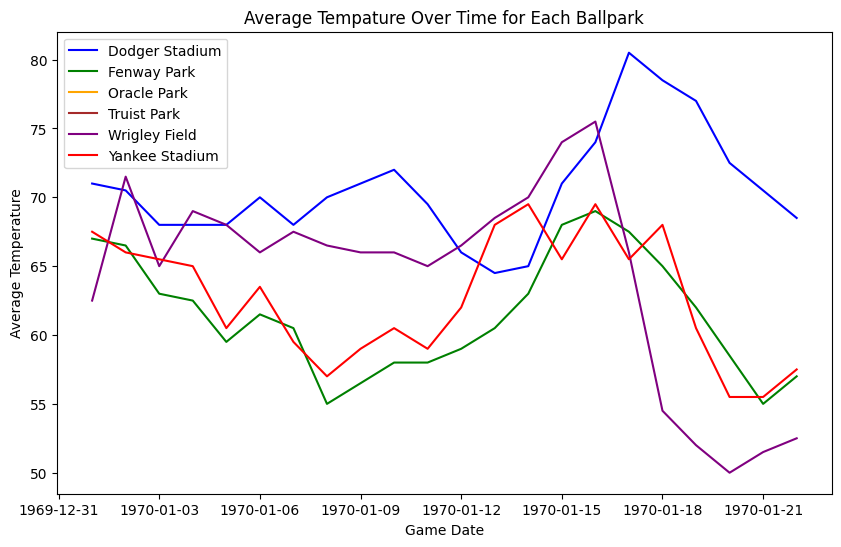

In [19]:
plt.figure(figsize=(10, 6))

colors = {
    'Dodger Stadium': 'blue',
    'Fenway Park': 'green',
    'Oracle Park': 'orange',
    'Truist Park': 'brown',
    'Wrigley Field': 'purple',
    'Yankee Stadium': 'red'
}


for ballpark, ballpark_data in weather.groupby('ballpark'):
    plt.plot(ballpark_data['game_date'], ballpark_data['TAVG'], label=ballpark, color=colors.get(ballpark, 'black'))

plt.title('Average Tempature Over Time for Each Ballpark')
plt.xlabel('Game Date')
plt.ylabel('Average Temperature')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend()

plt.show()

### Savant Data and Weather Cross Over

Here we will be merging the MLB Savant and NOAA data to match the observed weather of a given day to the date of an observed game + pitch. This will help with discovering relationships between weather conditions and pitch statistics.

In [20]:
weather['game_date'] = pd.to_datetime(weather['game_date'])
df_stadium['game_date'] = pd.to_datetime(df_stadium['game_date'])

weather_sav_df = pd.merge(df_stadium, weather, on=['game_date', 'ballpark'], how='inner')

Drop NaNs for TAVG

In [21]:
weather_sav_df = weather_sav_df.dropna(subset='TAVG').copy()

### Top Pitch Type Thrown In Each Stadium

Shown below is a summary of pitch types thrown in a selection of MLB stadiums, highlighting that certain stadiums see more of certain pitches than others. This may indicate the preferences of each team's pitchers, or the pitching strategy employed by each team.

In [22]:
weather_sav_df.groupby(['ballpark', 'pitch_name']).size().to_frame('Pitch_Amounts').sort_values(by=['ballpark', 'Pitch_Amounts'], ascending=False)

Pitch_Amounts
ballpark       pitch_name                    
Yankee Stadium 4-Seam Fastball            214
               Sinker                     162
               Sweeper                     97
               Changeup                    85
               Cutter                      85
               Slider                      84
               Knuckle Curve               39
               Curveball                   20
Wrigley Field  4-Seam Fastball            254
               Sinker                     177
               Slider                      96
               Changeup                    75
               Sweeper                     66
               Cutter                      62
               Knuckle Curve               29
               Curveball                   27
               Slurve                      19
               Split-Finger                 5
Fenway Park    4-Seam Fastball            175
               Sinker                     152
               Slider                     141
               Changeup                    66
               Sweeper                     54
               Curveball                   36
               Cutter                      27
               Knuckle Curve               13
               Split-Finger                13
Dodger Stadium 4-Seam Fastball            319
               Slider                     136
               Changeup                    99
               Cutter                      96
               Sinker                      73
               Curveball                   67
               Sweeper                     24
               Split-Finger                16
               Knuckle Curve                2

Average Tempature By Stadium

In [23]:
weather_sav_df.groupby(['ballpark'])['TMIN'].mean()

ballpark
Dodger Stadium    61.842548
Fenway Park       54.379616
Wrigley Field     62.129630
Yankee Stadium    57.947837
Name: TMIN, dtype: float64

In [24]:
weather_sav_df.columns

Index(['ballpark', 'left_field', 'center_field', 'right_field',
       'min_wall_height', 'max_wall_height', 'hr_park_effects',
       'extra_distance', 'avg_temp', 'elevation', 'roof', 'daytime',
       'player_name', 'pitch_type', 'pitch_name', 'release_speed', 'game_date',
       'release_spin_rate', 'description', 'events', 'hit_distance_sc',
       'pitch_number', 'strikes', 'balls', 'home_team', 'inning',
       'outs_when_up', 'type', 'zone', 'spin_axis', 'effective_speed',
       'at_bat_number', 'TMIN', 'TMAX', 'TAVG'],
      dtype='object')

### Total Pitches Thrown

Shown below is a summary of the number of instances in which a pitcher threw a certain number of pitches. The distribution of the graph indicates that pitchers tend to either throw a small number of pitches (10-20), or around 100 pitches in a game.

In [25]:
total_pitches_df = weather_sav_df.groupby(['player_name', 'game_date']).size().to_frame('Total Pitches')

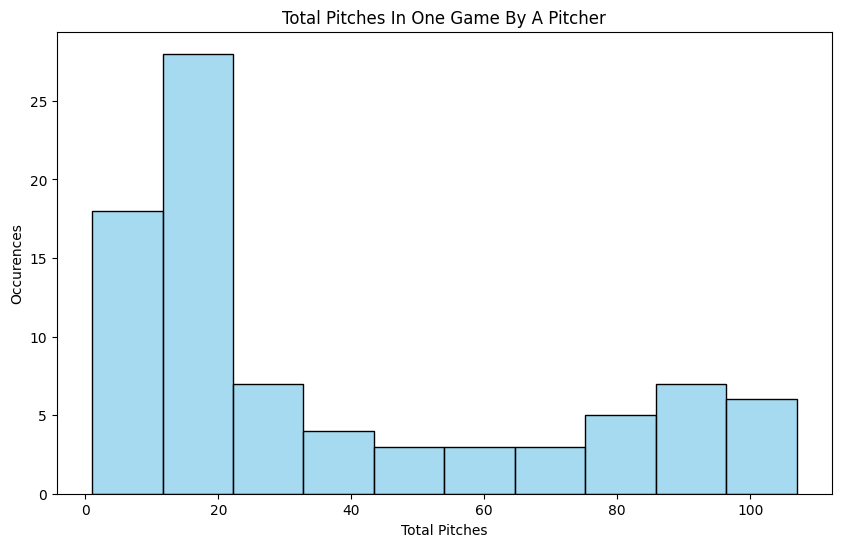

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(total_pitches_df['Total Pitches'], bins=10, kde=False, color='skyblue')

plt.xlabel('Total Pitches')
plt.ylabel('Occurences')
plt.title('Total Pitches In One Game By A Pitcher')
plt.show()

#### Spin Rate and Release Speed Over The Course of a Game

Selecting two high pitch count games, we aim to display any changes in the spin rate and release speed of pitches over the course of a single MLB game. As pitchers continuously throw, their arms may tire out, affecting the speed and spin of a pitch by the end of the game.

In [27]:
total_pitches_df[total_pitches_df['Total Pitches'] > 90]

,,Total Pitches
player_name,game_date,
"Bello, Brayan",2023-09-27,100
"Cole, Gerrit",2023-09-21,107
"Crawford, Kutter",2023-09-24,93
"Hendricks, Kyle",2023-09-21,95
"King, Michael",2023-09-20,101
"Lynn, Lance",2023-09-24,99
"Miller, Bobby",2023-09-20,98
"Pivetta, Nick",2023-09-23,92
"Rodón, Carlos",2023-09-24,93


We selected Gerrit Cole and Michael King, as they had each thrown over 100 pitches in a single game. From here we will analyze 4-Seam fastballs only in order to show trends over the same pitch type. 

In [28]:
dates = pd.to_datetime(['2023-09-21', '2023-09-20'])

two_hp_games = weather_sav_df[(weather_sav_df['player_name'].isin(['King, Michael', 'Cole, Gerrit'])) & (weather_sav_df['game_date'].isin(dates))]

In [29]:
two_hp_games['player_name'].unique()

array(['Cole, Gerrit', 'King, Michael'], dtype=object)

In [30]:
garrit_df = two_hp_games.query('player_name == "Cole, Gerrit"')
king_df = two_hp_games.query('player_name == "King, Michael"')

Sorting for innings and outs, so a progression series can be constructed.

In [31]:
innings_outs_sorted_g_df = garrit_df.sort_values(by=['inning', 'outs_when_up'])
f_seams_g_df = innings_outs_sorted_g_df.query('pitch_name == "4-Seam Fastball"')

innings_outs_sorted_k_df = king_df.sort_values(by=['inning', 'outs_when_up'])
f_seams_k_df = innings_outs_sorted_k_df.query('pitch_name == "4-Seam Fastball"')

In [32]:
# Create explicit copies of the slices to avoid SettingWithCopyWarning
f_seams_g_df = f_seams_g_df.copy()
f_seams_k_df = f_seams_k_df.copy()

f_seams_g_df.loc[:, 'progression'] = range(1, len(f_seams_g_df) + 1)
f_seams_k_df.loc[:, 'progression'] = range(1, len(f_seams_k_df) + 1)

### Union two games

In [33]:
concat_two_games = pd.concat([f_seams_g_df, f_seams_k_df])

Creating progression feature from first to last fastball

Plot Spin Rate and Release Speed for Fastball Progression

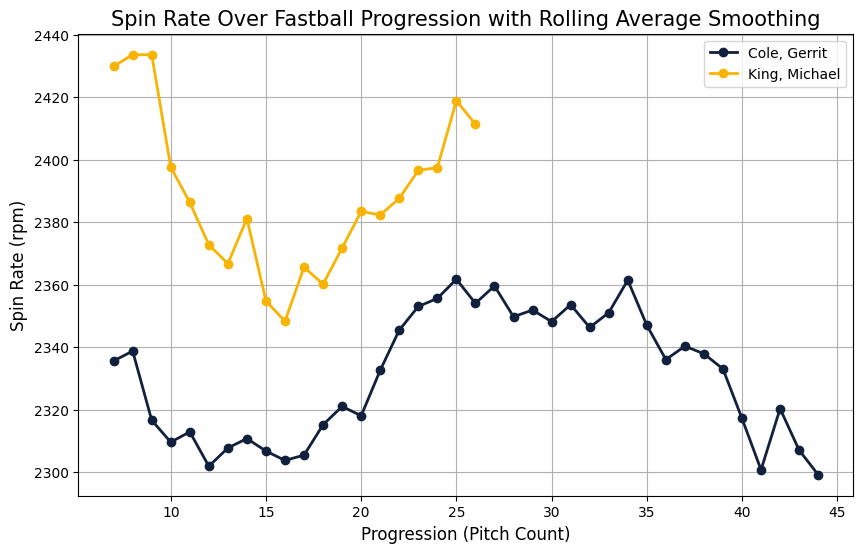

In [34]:
plt.figure(figsize=(10, 6))

color_dict = {
    'Cole, Gerrit': '#11203d',
    'King, Michael': '#f8b405'
}


for player in concat_two_games['player_name'].unique():
    player_data = concat_two_games[concat_two_games['player_name'] == player]
    plt.plot(player_data['progression'], player_data['release_spin_rate'].rolling(window=7).mean(),  marker='o', color=color_dict[player], linestyle='-', linewidth=2, label=player)

plt.xlabel('Progression (Pitch Count)', fontsize=12)
plt.ylabel('Spin Rate (rpm)', fontsize=12)
plt.title('Spin Rate Over Fastball Progression with Rolling Average Smoothing', fontsize=15)

plt.grid(True)
plt.legend()
plt.show()

### Next Steps

1. We plan to test if there is a statistically significant positive correlation between warmer weather and decreased spin rates as the game progresses.

2. We plan to test if there is a statistically significant positive correlation between higher spin rates and strikeouts.

Change this out for next steps:

LSVM, and Random Forest on using Target as Type, and features are pitching things. We want to do a regression line for off-speed pitches, similar to the money ball dataset.

In [35]:
# New dataframe for model testing
data = weather_sav_df[['type', 'pitch_number', 'outs_when_up', 'inning', 'release_speed', 'release_spin_rate', 'strikes', 'balls',
                       'zone', 'spin_axis', 'effective_speed', 'at_bat_number']]

# Only test for strikes and balls, not hit in play (X)
test_models_df = data[data['type'].isin(['S', 'B'])].copy()

# Encode the target variable
test_models_df['type'] = test_models_df['type'].map({'S': 0, 'B': 1})
features = test_models_df.drop(columns=['type'])
target = test_models_df['type']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Random Forest

In [36]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Distribution of resampled target
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())

# Define Random Forest Model
randomf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Trail the model
randomf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = randomf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Evaluation
print('\n')
print(f'Random Forest Classification Report with SMOTE')
print(classification_report(y_test, y_pred))
print('\n')
print(f'Model Accuracy: {accuracy:.2f}')


Class distribution after SMOTE: type
0    1183
1    1183
Name: count, dtype: int64


Random Forest Classification Report with SMOTE
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       294
           1       0.74      0.93      0.82       224

    accuracy                           0.83       518
   macro avg       0.83      0.84      0.83       518
weighted avg       0.85      0.83      0.83       518



Model Accuracy: 0.83


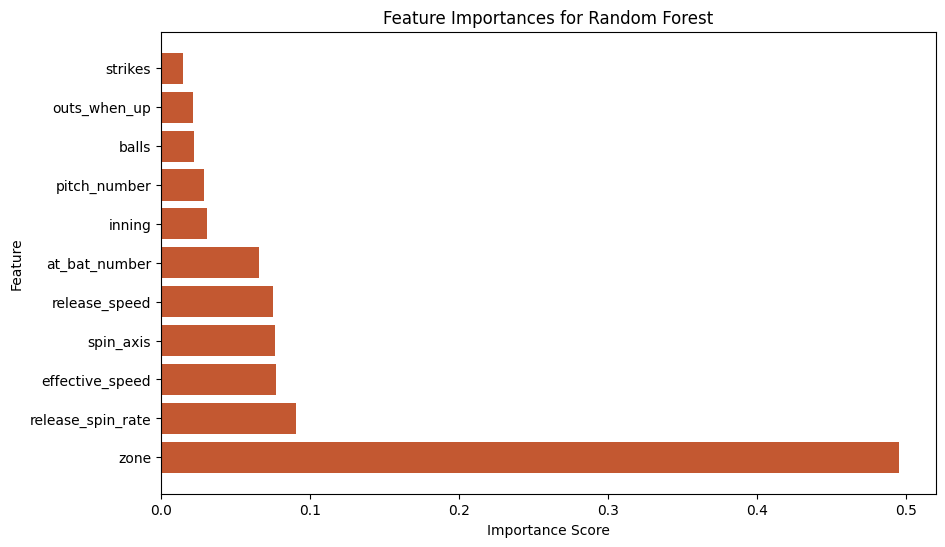

In [37]:
# Feature visualization
importances = randomf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#C35831')
plt.gca().invert_yaxis()
plt.title('Feature Importances for Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()